# Government licenses analysis

In this notebook, we'll analyse a list of licenses gathered from government websites, comparing them among each other and with known licenses. We want to find out:

* Which licenses are standard (i.e. not custom)
* Are there licenses very similar, indicating they came from the same place?

In [119]:
import os
import re
import glob
import csv
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DATA_PATH = os.path.join(os.getcwd(), '..', 'data')
LICENSES_PATH = os.path.join(DATA_PATH, 'gov_licenses.csv')
KNOWN_LICENSES_PATH = os.path.join(DATA_PATH, 'licenses', '*.txt')
LICENSE_TEXT_COL = 'License text (original)'

def load_csv(path):
    with open(path, 'r') as fp:
        reader = csv.DictReader(fp)
        return [row for row in reader]
    
def load_known_licenses(path):
    def _load_license(text):
        matches = re.split(r'[^-]---\w*\n', text)

        if not matches:
            return

        assert len(matches) == 2, 'Wrong matches'
        metadata, text = matches

        license = yaml.load(metadata)
        license['text'] = text.strip()

        return license

    licenses = []

    for filepath in glob.iglob(path):
        _, filename = os.path.split(filepath)
        text = open(filepath, 'r').read()
        licenses.append(_load_license(text))

    return licenses

licenses = load_csv(LICENSES_PATH)
known_licenses = load_known_licenses(KNOWN_LICENSES_PATH)

## Prepare data for comparisons

Here we clean and prepare the licenses' data to detect similarities among them.

In [120]:
import sklearn.metrics
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

def get_min_distances(distances, is_pairwise=False):
    result = []
    
    for index, distance in enumerate(distances):
        mask = np.full(len(distance), True)
        
        if is_pairwise:
            # Remove the current distance from the list of possibilities
            # otherwise we'll always find out that the closest point is itself
            # (distance == 0)
            np.put(mask, index, False)
            
        min_distance = distance[mask].min()

        result.append({
            'index': index,
            'distance': min_distance,
            'min_indexes': np.where(distance == min_distance)[0],
        })

    return result

pipeline = make_pipeline(
    TfidfVectorizer(stop_words='english', norm='l2', sublinear_tf=True)
)

gov_licenses_data = [
    {'index': index, 'type': 'gov', 'text': license[LICENSE_TEXT_COL]}
    for index, license in enumerate(licenses)
]

known_licenses_data = [
    {'index': index, 'type': 'known', 'text': license['text']}
    for index, license in enumerate(known_licenses)
]

prepared_data = np.array(gov_licenses_data + known_licenses_data)

# We need this to create the masks (there's certainly a better way, but I don't know)
prepared_data_types = np.array([data['type'] for data in prepared_data])
gov_mask = prepared_data_types == 'gov'
known_licenses_mask = prepared_data_types == 'known'

X = pipeline.fit_transform([
    data['text'] for data in prepared_data
])

## Compare government's licenses to known licenses

We're trying to determine how similar the government licenses are to a few known licenses. Them being similar can mean they're using the same license (changing things like year of copyrigh holder names), or that they were based in them.

/home/vitor/Projetos/okfn/licenses_analysis/.tox/start/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, _DataConversionWarning)


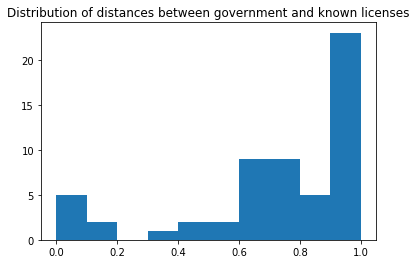

,closest_match,distance,license_text,row
0,Open Data Commons Open Database License (ODbL),0.000000,ODC Open Database License (ODbL)\nPreamble\nTh...,21
1,Creative Commons Attribution 4.0,0.067938,Creative Commons Attribution 4.0 International...,2
2,Open Government License 1.0,0.078300,You are encouraged to use and re-use the Infor...,59
3,Open Government License 3.0,0.085586,You are encouraged to use and re-use the Infor...,55
4,Open Government License 2.0,0.091335,You are encouraged to use and re-use the Infor...,57
5,Creative Commons Attribution 4.0,0.129608,Open Geo-coded National Address File (G-NAF) E...,6
6,Open Government License 2.0,0.196891,Open Parliament Licence\nYou are encouraged to...,58
7,Open Government License 2.0,0.376404,Open Government Licence - Canada\nFollow:Twitt...,8
8,Creative Commons Attribution 4.0,0.468889,Attribution 3.0 Australia\n\nCREATIVE COMMONS ...,3
9,Creative Commons Attribution Share Alike 4.0,0.490239,Attribution 2.5 Australia\n\nCREATIVE COMMONS ...,4


In [121]:
def generate_df(min_distances, X, y):
    ROW_OFFSET = 2  # 1 for the header, and 1 because it starts in 1, not 0 like lists
    pairs_seen = set()
    result = []
    for potential in sorted(min_distances, key=lambda x: x['distance']):
        index = potential['index']
        min_index = potential['min_indexes'][0]
        pair = ','.join(sorted((str(index), str(min_index))))
        
        if pair in pairs_seen:
            continue
            
        pairs_seen.add(pair)

        data = {
            'distance': potential['distance'],
            'row': index + ROW_OFFSET,
            'license_text': X[index][LICENSE_TEXT_COL],
            'closest_match': y[min_index]['title'],
        }
        result.append(data)

    return pd.DataFrame(result)

distances_to_known_licenses = sklearn.metrics.pairwise.pairwise_distances(
    X[gov_mask].todense(),
    X[known_licenses_mask].todense(),
    metric='dice'
)

min_distances = get_min_distances(distances_to_known_licenses)

plt.hist([d['distance'] for d in min_distances])
plt.title("Distribution of distances between government and known licenses")
plt.show()

display(generate_df(min_distances, licenses, known_licenses))

## Comparing government licenses among themselves

We're comparing every pair of government licenses, and selecting the closest matches.

/home/vitor/Projetos/okfn/licenses_analysis/.tox/start/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, _DataConversionWarning)


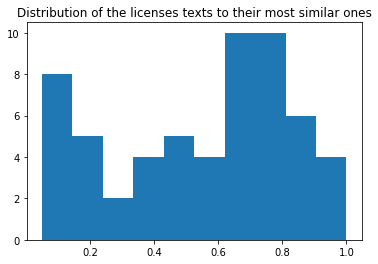

,distance,license_1,license_1.row,license_2,license_2.row
0,0.050398,CONDICIONES Y TÉRMINOS DE USO DE LA INFORMACIÓ...,39,CONDICIONES Y TÉRMINOS DE USO\nLas presentes c...,40
1,0.059072,You are encouraged to use and re-use the Infor...,55,You are encouraged to use and re-use the Infor...,57
2,0.076531,Creative Commons Attribution 4.0 International...,2,Open Geo-coded National Address File (G-NAF) E...,6
3,0.080169,You are encouraged to use and re-use the Infor...,59,You are encouraged to use and re-use the Infor...,57
4,0.126492,Cláusula de Licencia Abierta (OpenDefinition) ...,41,CONDICIONES Y TÉRMINOS DE USO\nLas presentes c...,40
5,0.188011,Notice on Copyright and Other Related Matters ...,42,Terms of Use\nUsing the content on this websit...,46
6,0.190588,Open Parliament Licence\nYou are encouraged to...,58,You are encouraged to use and re-use the Infor...,57
7,0.199564,Attribution 3.0 Australia\n\nCREATIVE COMMONS ...,3,Attribution 2.5 Australia\n\nCREATIVE COMMONS ...,4
8,0.324397,Terms of use on this website\n· About the use ...,43,Terms of service\nAbout the use of the content...,45
9,0.346154,Acceptance & Grant of Licence\nBy Using (as de...,52,API Terms of Service\nAcceptance of API Terms ...,54


In [122]:
def generate_df(min_distances):
    ROW_OFFSET = 2  # 1 for the header, and 1 because it starts in 1, not 0 like lists
    pairs_seen = set()
    result = []
    for potential in sorted(min_distances, key=lambda x: x['distance']):
        index = potential['index']
        min_index = potential['min_indexes'][0]
        pair = ','.join(sorted((str(index), str(min_index))))
        
        if pair in pairs_seen:
            continue
            
        pairs_seen.add(pair)
        
        data = {
            'distance': potential['distance'],
            'license_1.row': index + ROW_OFFSET,
            'license_2.row': min_index + ROW_OFFSET,
            'license_1': licenses[index][LICENSE_TEXT_COL],
            'license_2': licenses[min_index][LICENSE_TEXT_COL],
        }
        result.append(data)

    return pd.DataFrame(result)

distances_among_themselves = sklearn.metrics.pairwise.pairwise_distances(
    X[gov_mask].todense(),
    metric='dice'
)

min_distances = get_min_distances(distances_among_themselves, is_pairwise=True)
plt.hist([d['distance'] for d in min_distances])
plt.title("Distribution of the licenses texts to their most similar ones")
plt.show()

display(generate_df(min_distances))